In [1]:
import os
import shutil
import time
from threading import Timer
from time import gmtime, strftime
import numpy as np
from matplotlib import pyplot
from skimage import measure
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import shape
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


import warnings
import csv
warnings.filterwarnings(action='ignore') 

In [2]:
# Global variables:
systemCooldown = 2
Error_Limit = 1
mode = True

In [3]:
# File Paths
Drive = "/Users/imdsk/RIDAProjectBurnScar/Sentinel_Process/"
Image = os.path.join(Drive, "Image")
Image_Pre = os.path.join(Drive, "Image_Pre/")
Image_Finish = os.path.join(Drive, "Image_Finish/")
Image_Missing = os.path.join(Drive, "Image_Missing/")
Output = os.path.join(Drive, "Output/")
Rtbcon = os.path.join(Drive, "Raster_BurnCon/")
Rtbreg = os.path.join(Drive, "Raster_BurnReg/")
RtbShape = os.path.join(Drive, "Raster_BurnShape/")
Track_arr = ["T4/", "T104/", "T61/", "T18/", "T118/"]
# Track_arr = ["T4/", "T104/", "T61/", "T18/", "T118/"]

In [4]:
# Function to load cooldown
def loadCooldown():
    global mode

In [5]:
# Function to print time
def print_time():
    return time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

In [6]:
# Function to move file
def Move_File(FileName, CurrDir, DestDir):
    try:
        if os.path.exists(os.path.join(CurrDir, FileName)):
            if os.path.exists(os.path.join(DestDir, FileName)):
                os.remove(os.path.join(DestDir, FileName))
            shutil.copy(os.path.join(CurrDir, FileName), DestDir)
            t = Timer(1, loadCooldown)
            t.start()
            t.join()
            os.remove(os.path.join(CurrDir, FileName))
            print(print_time() + f"Raster_Process :: Move File {FileName} Complete")
    except Exception as e:
        print(print_time() + f"Raster_Process :: Can not Move File {FileName}")
        print(print_time() + str(e))

In [7]:
def write_to_csv(data, file_name_csv):
    try:
        # Convert NumPy array to a nested Python list or dictionary
        if isinstance(data, np.ndarray):
            data_list = data.tolist()  # Convert ndarray to a nested list
        else:
            data_list = data  # For other non-ndarray data, assume it's already in list format

        # Write to CSV file
        with open(file_name_csv, 'w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            for row in data_list:
                csv_writer.writerow(row)
        print(f"Data successfully written to {file_name_csv}")

    except Exception as e:
        print(f"Error writing to CSV file: {e}")

In [8]:
def print_with_tag(data, tag):
    print("------")
    print(tag)
    print(data)
    print("------")
    

In [9]:
# Function to process raster

def Raster_Process(Track):
    global mode, Image, Image_Pre, Image_Finish, Image_Missing, Output, Error_Limit

    Loop_Limit = 0
    image_track = os.path.join(Image, Track)
    output_track = os.path.join(Output, Track)

    rasters = [r for r in os.listdir(image_track) if r.endswith('B12.jp2')]

    for raster in rasters:
        if Loop_Limit > 0:
            mode = True
            return

        Full_name = os.path.splitext(raster)[0]
        Full_name_parts = Full_name.split('_')
        Mid_name = Full_name[:23]
        Short_name = Full_name[:6]
        # Short_name = Full_name_parts[0] + '_' + Full_name_parts[1]
        # print(Full_name)
        # print(Short_name)

        BFB02 = os.path.join(Image_Pre, Track, f"{Short_name}_B02.jp2")
        BFB03 = os.path.join(Image_Pre, Track, f"{Short_name}_B03.jp2")
        BFB04 = os.path.join(Image_Pre, Track, f"{Short_name}_B04.jp2")
        BFB08 = os.path.join(Image_Pre, Track, f"{Short_name}_B08.jp2")
        BFB12 = os.path.join(Image_Pre, Track, f"{Short_name}_B12.jp2")
        BFB1210 = os.path.join(Image_Pre, Track, f"{Short_name}_B1210.jp2")
        BFNBR = os.path.join(Image_Pre, Track, f"{Short_name}_NBR.tif")

        AFB02 = os.path.join(Image, Track, f"{Mid_name}B02.jp2")
        AFB03 = os.path.join(Image, Track, f"{Mid_name}B03.jp2")
        AFB04 = os.path.join(Image, Track, f"{Mid_name}B04.jp2")
        AFB08 = os.path.join(Image, Track, f"{Mid_name}B08.jp2")
        AFB12 = os.path.join(Image, Track, f"{Mid_name}B12.jp2")
        AFB1210 = os.path.join(Image, Track, f"{Mid_name}B1210.jp2")

        print(BFB12)
       

        if all(
            [
                
                os.path.exists(BFB02),os.path.exists(BFB03), os.path.exists(BFB04), os.path.exists(BFB08), os.path.exists(BFB12),
                os.path.exists(AFB02),os.path.exists(AFB03), os.path.exists(AFB04), os.path.exists(AFB08), os.path.exists(AFB12)
            ]
        ):
            print(print_time() + "Raster_Process :: Start GIS Process Please Wait....")
            Loop_Limit += 1
            # Delete Old File
            print(print_time() + "Raster_Process :: Delete Old File")
            files = os.listdir(output_track)
            for f in files:
                try:
                    os.remove(os.path.join(output_track, f))
                except Exception as e:
                    print(print_time() + f"Raster_Process :: Cannot Delete {f}")
                    print(print_time() + str(e))
                    break

            print(print_time() + "Raster_Process :: Delete Old File Complete")
            t = Timer(3, loadCooldown)
            t.start()
            t.join()

            def resample_raster(input_raster, output_raster, new_resolution):
                with rasterio.open(input_raster) as src:
                    transform = src.transform
                    data = src.read(
                        out_shape=(
                            src.count,
                            int(src.height * src.transform.a / new_resolution),
                            int(src.width * src.transform.a / new_resolution)
                        ),
                        resampling=Resampling.nearest  # You can adjust the resampling method here
                    )
                    profile = src.profile
                    profile.update(transform=transform, width=data.shape[2], height=data.shape[1])

                    with rasterio.open(output_raster, 'w', **profile) as dst:
                        dst.write(data)


            def save_as_geotiff(data, output_path, resolution=10):
                height, width = data.shape

                # Define the transformation
                transform = from_origin(0, height * resolution, 0, 0, width * resolution, -resolution)

                # Define the profile
                profile = {
                    'driver': 'GTiff',
                    'count': 1,
                    'dtype': 'uint8',
                    'width': width,
                    'height': height,
                    'crs': 'EPSG:4326',  # Adjust the CRS as needed
                    'transform': transform,
                    'compress': 'packbits',
                    'tiled': True,
                    'interleave': 'band',
                }

                with rasterio.open(output_path, 'w', **profile) as dst:
                    dst.write(data.astype('uint8'), 1)
                            

            if os.path.exists(BFB1210) == False:
                print(print_time() + "Raster_Process :: Resample " + Short_name)

                    # Usage:
                input_raster = BFB12
                output_raster = BFB1210
                new_resolution = 10  # Change this to the desired resolution

                resample_raster(input_raster, output_raster, new_resolution)


            if os.path.exists(BFNBR) == False:
                print(print_time()+"Raster_Process :: NBR " + Short_name)
                with rasterio.open(BFB08) as src_BFB08, rasterio.open(BFB1210) as src_BFB1210:
                    data_BFB08 = src_BFB08.read(1)  # Read the data of BFB08 raster band 1
                    data_BFB1210 = src_BFB1210.read(1)  # Read the data of BFB1210 raster band 1

                    NBR_data = (data_BFB08 - data_BFB1210) / (data_BFB08 + data_BFB1210)

                    profile = src_BFB08.profile  # Use BFB08 profile as a template for the new raster
                    output_path_NBR = Image_Pre + Track + Short_name + "_NBR.tif"
                    with rasterio.open(output_path_NBR, 'w', **profile) as dst:
                        dst.write(NBR_data, 1)


            if os.path.exists(AFB1210) == False:
                print(print_time()+"Raster_Process :: Resample " + Mid_name)

                # Usage:
                input_raster = AFB12
                output_raster = AFB1210
                new_resolution = 10 

                resample_raster(input_raster, output_raster, new_resolution)
                # arcpy.Resample_management(AFB12, Image + Track + Mid_name + "B1210.jp2","10 10","NEAREST")

            try:
                ########################################## Raster PROCESS ################################################
                print(print_time()+"Raster_Process :: Raster Process " + Full_name[:22])

                with rasterio.open(BFNBR) as src_BFNBR, rasterio.open(AFB08) as src_AFB08, rasterio.open(AFB1210) as src_AFB1210, rasterio.open(AFB04) as src_AFB04, rasterio.open(AFB03) as src_AFB03,rasterio.open(AFB02) as src_AFB02:
                    data_BFNBR = src_BFNBR.read(1) 
                    data_AFB02 = src_AFB02.read(1)  
                    data_AFB03 = src_AFB03.read(1)  
                    data_AFB04 = src_AFB04.read(1)  
                    data_AFB08 = src_AFB08.read(1) 
                    data_AFB1210 = src_AFB1210.read(1)  

                    print_with_tag(data_BFNBR,'data_BFNBR')
                    print_with_tag(data_AFB02, 'data_AFB03')
                    print_with_tag(data_AFB03, 'data_AFB03')
                    print_with_tag(data_AFB08, 'data_AFB08')
                    print_with_tag(data_AFB1210, 'data_AFB1210')


                    PreNBR_data = (data_BFNBR)
                    print_with_tag(PreNBR_data, 'PreNBR_data')
                    PostNBR_data = (data_AFB08 - data_AFB1210) / (data_AFB08 + data_AFB1210)
                    print_with_tag(PostNBR_data, 'PostNBR_data')

                    # PNDVI_data = (data_AFB08 - data_AFB04) / (data_AFB08 + data_AFB04)
                    

                ########################################## Burn Condition ################################################
               
                print(print_time()+"Raster_Process :: Burn Raster Condition")

                
                dNBR = PreNBR_data - PostNBR_data
                write_to_csv(dNBR, '[CSV]dNBR.csv')
                print(dNBR)
                print("before condition")


                def burn_con(dNBR, data_AFB03,data_AFB04, data_AFB08, output_path):
                    # burnCon_LV1 = np.where(((dNBR > 0.44) & (PostNBR_data < 0)), 1, 0)
                    burnCon_LV1 = np.where(((dNBR > 0.27) & (PostNBR_data < 0.10)),1,0) 
                    write_to_csv(burnCon_LV1, '[CSV]burncon_lv1.csv')
                    print(burnCon_LV1)
                    print("After Lv1")

                    burnCon_Final = np.where(((burnCon_LV1 == 1) & (data_AFB08 < 2500) & (data_AFB08 > data_AFB03)), 1, 0)
                    # burnCon_Final = np.where(((burnCon_LV1 == 1) & (data_AFB08 < 2000) & (data_AFB08 > data_AFB03)), 1, 0)
                    write_to_csv(burnCon_Final, '[CSV]burnCon_Final.csv')
                    print(burnCon_Final)
                    print("After condition final")
                    

                    # Save the result to a GeoTIFF file
                    save_as_geotiff(burnCon_Final, output_path)

                
                def save_as_geotiff(data, output_path, resolution=10):
                    height, width = data.shape

                    # Define the transformation
                    transform = from_origin(0, height * resolution, resolution, -resolution)

                    # Define the profile
                    profile = {
                        'driver': 'GTiff',
                        'count': 1,
                        'dtype': 'uint8',
                        'width': width,
                        'height': height,
                        'crs': 'EPSG:4326',  # Adjust the CRS as needed
                        'transform': transform,
                        'compress': 'packbits',
                        'tiled': True,
                        'interleave': 'band',
                    }

                    with rasterio.open(output_path, 'w', **profile) as dst:
                        dst.write(data.astype('uint8'), 1)

                # Example usage
                output_path = Rtbcon + Track + Full_name + ".tif"
                burn_con(dNBR, data_AFB03,data_AFB04, data_AFB08, output_path)

        
                
                del dNBR
                del PreNBR_data
                del PostNBR_data
                ##########################################################################################################

                

                threshold_value = 10
                print(print_time()+"Raster_Process :: RegionGroup")

                # BCON = os.path.join(Rtbcon, Track, f"{Short_name}_B12.tif")
                BCON = os.path.join(Rtbcon, Track, f"{Full_name}.tif")
                

                with rasterio.open(BCON) as src_BCON:
                    data_BCON = src_BCON.read(1) 


                def burn_region(data_BCON, track, full_name):
                    # Perform BurnRegion operations here
                    burnRegionGrp = measure.label(data_BCON, connectivity=2)  # Equivalent to RegionGroup
                    print(print_time() + f"Raster_Process :: Region > {threshold_value}")

                    # Use numpy to create a mask where count > 400
                    burnRegionGrpThresholded = np.where(burnRegionGrp > threshold_value, 1, 0)
                    write_to_csv(burnRegionGrpThresholded, '[CSV]burnRegionGrpThresholded.csv')
                    print(burnRegionGrpThresholded)
                    print("After burnRegionGrpThresholded")


                    burnRegion = np.where(burnRegionGrpThresholded == 1, 1, 0)
                    write_to_csv(burnRegion, '[CSV]burnRegion.csv')
                    print(burnRegion)
                    print("After burnRegion")

                    

                    print(print_time() + "Raster_Process :: Save Raster")

                    output_path = Rtbreg + track + Short_name+ "_B12" + ".tif"
                    # output_path = Rtbreg + track + full_name+ ".tif"
                    save_as_geotiff(burnRegion, output_path)
                    

                burn_region(data_BCON, Track, Full_name)


                print(print_time()+"Raster_Process :: Burn Raster Process Complate")

                ########################################## Vecter PROCESS #################################################
                def reclassify_raster(input_raster, output_raster, remap_dict):
                    with rasterio.open(input_raster) as src:
                        data = src.read(1)  # Assuming a single-band raster, adjust if necessary
                        profile = src.profile

                        # Reclassify using numpy's vectorized operations
                        for old_value, new_value in remap_dict.items():
                            data = np.where(data == old_value, new_value, data)

                        with rasterio.open(output_raster, 'w', **profile) as dst:
                            dst.write(data, 1)

                # Example usage:
                burnRegion = os.path.join(Rtbreg, Track, f"{Short_name}_B12.tif")
                burnReclass = os.path.join(Rtbreg, Track, f"{Short_name}_BurnReclass.tif")
                remap_dict = {1: 1}  # Add your reclassification rules here

                reclassify_raster(burnRegion, burnReclass, remap_dict)

                print("After burn reclasss")
                
            

                def raster_to_polygon(input_raster, output_shapefile, simplify=0, value_field="VALUE"):
                    with rasterio.open(input_raster) as src:
                        image = src.read(1)

                        # Get shapes and transform
                        shapes = rasterio.features.shapes(image, transform=src.transform)

                        # Create lists to collect geometries and values
                        geometries = []
                        values = []

                        for geom, value in shapes:
                            if simplify > 0:
                                geom = shape(geom).simplify(simplify)

                            geometries.append(geom)
                            values.append(value)

                        # Create GeoDataFrame
                        gdf = gpd.GeoDataFrame({value_field: values, 'geometry': geometries})

                        # Simplify each geometry in the GeoDataFrame
                        if simplify > 0:
                            gdf['geometry'] = gdf['geometry'].apply(lambda x: x.simplify(simplify))

                        # Dissolve overlapping polygons
                        dissolved_gdf = gdf.dissolve(by=value_field)

                        # Write to shapefile
                        dissolved_gdf.to_file(output_shapefile)

                # Example usage:
                burnReclass = os.path.join(Rtbreg, Track, f"{Short_name}_BurnReclass.tif")
                output_shapefile = RtbShape + Track + Short_name+ "_B12" + ".shp"
                simplify_value = 0.1  # Adjust this value if needed

                raster_to_polygon(burnReclass, output_shapefile, simplify=simplify_value)
                
                print(print_time()+"Raster_Process :: Start Move File ")
                Move_File(Mid_name + "B03.jp2", Image + Track, Image_Finish + Track)
                Move_File(Mid_name + "B04.jp2", Image + Track, Image_Finish + Track)
                Move_File(Mid_name + "B08.jp2", Image + Track, Image_Finish + Track)
                Move_File(Mid_name + "B12.jp2", Image + Track, Image_Finish + Track)
                Move_File(Mid_name + "B1210.jp2", Image + Track, Image_Finish + Track)
                Move_File(Mid_name + "B1210.jp2.aux.xml", Image + Track, Image_Finish + Track)
                Move_File(Mid_name + "B1210.jp2.ovr", Image + Track, Image_Finish + Track)
                Move_File(Mid_name + "B1210.jp2.xml", Image + Track, Image_Finish + Track)
                Error_Limit = 2
                print(print_time()+"Raster_Process :: Raster_Process ALL Complate >>>>>>>>>>>>>>>>>>>> \n \n")



                # Load the shapefile and image

                
                shapefile_path = os.path.join(RtbShape, Track, f"{Short_name}_B12.shp")
                image_path = os.path.join(Image, Track, f"{Full_name}10.jp2")

                gdf = gpd.read_file(shapefile_path)

                # Plot the image
                image = plt.imread(image_path)
                fig, ax = plt.subplots(figsize=(10, 10))
                ax.imshow(image, cmap='gray')

                # Plot the shapefile on top of the image
                gdf.plot(ax=ax, color='red', edgecolor='black', alpha=0.5)

                # Customize the plot
                legend_elements = [Patch(facecolor='red', edgecolor='black', alpha=0.5, label='Shapefile')]
                ax.legend(handles=legend_elements, loc='upper right')
                ax.set_title('Shapefile on Top of Image')

                # Show the plot
                plt.show()

                ###########################################################################################################

            except Exception as e:
                print(print_time()+"Raster_Process :: !!!!!!!!!! RASTER ERROR !!!!!!!!!!")
                print(print_time() + str(e))
                Error_Limit = Error_Limit - 1
                if Error_Limit < 1 :
                    print(print_time()+"Raster_Process :: !!!!!!!!!! RASTER ERROR 2 Time MoveFile to Image_Missin")
                    Move_File(Mid_name + "B03.jp2", Image + Track, Image_Missing + Track)
                    Move_File(Mid_name + "B04.jp2", Image + Track, Image_Missing + Track)
                    Move_File(Mid_name + "B08.jp2", Image + Track, Image_Missing + Track)
                    Move_File(Mid_name + "B12.jp2", Image + Track, Image_Missing + Track)
                    Move_File(Mid_name + "B1210.jp2", Image + Track, Image_Missing + Track)
                    Move_File(Mid_name + "B1210.jp2.aux.xml", Image + Track, Image_Missing + Track)
                    Move_File(Mid_name + "B1210.jp2.ovr", Image + Track, Image_Missing + Track)
                    Move_File(Mid_name + "B1210.jp2.xml", Image + Track, Image_Missing + Track)
                    Error_Limit = 2
                    
            ############################################## END Raster PROCESS################################################
        
            # ... 
        
        else:
            print(print_time() + f"Raster_Process gg111 :: {Full_name[:22]} Image not Found !!!!")
            print(BFB03, "_", os.path.exists(BFB03))
            print(BFB04, "_", os.path.exists(BFB04))
            print(BFB08, "_", os.path.exists(BFB08))
            print(BFB12, "_", os.path.exists(BFB12))
            print(AFB03, "_", os.path.exists(AFB03))
            print(AFB04, "_", os.path.exists(AFB04))
            print(AFB08, "_", os.path.exists(AFB08))
           
            # print("Joined Path:", BFB03)

            Move_File(f"{Mid_name}B03.jp2", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
            Move_File(f"{Mid_name}B04.jp2", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
            Move_File(f"{Mid_name}B08.jp2", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
            Move_File(f"{Mid_name}B12.jp2", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
            Move_File(f"{Mid_name}B1210.jp2", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
            Move_File(f"{Mid_name}B1210.jp2.aux.xml", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
            Move_File(f"{Mid_name}B1210.jp2.ovr", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
            Move_File(f"{Mid_name}B1210.jp2.xml", os.path.join(Image, Track), os.path.join(Image_Missing, Track))
        
    print(print_time() + "Wait New Raster ::")
    mode = True

Current Working Directory: /Users/imdsk/RIDAProjectBurnScar
2024-02-05 18:48:39Application Start ::
2024-02-05 18:48:41Found NEW Raster :: 
/Users/imdsk/RIDAProjectBurnScar/Sentinel_Process/Image_Pre/T104/T47QNB_B12.jp2
2024-02-05 18:48:41Raster_Process :: Start GIS Process Please Wait....
2024-02-05 18:48:41Raster_Process :: Delete Old File
2024-02-05 18:48:41Raster_Process :: Delete Old File Complete
2024-02-05 18:48:44Raster_Process :: Raster Process T47QNB_20230325T034539
------
data_BFNBR
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------
------
data_AFB03
[[2589 2602 2598 ... 2974 2972 2960]
 [2589 2598 2583 ... 2965 2991 2976]
 [2591 2593 2581 ... 2968 2987 2975]
 ...
 [2591 2602 2657 ... 2665 2665 2666]
 [2662 2732 2739 ... 2650 2657 2656]
 [2756 2792 2692 ... 2640 2641 2644]]
------
------
data_AFB03
[[2335 2341 2350 ... 2722 2718 2718]
 [2326 2352 2352 ... 2723 2718 2720]
 [2335 2344 2326 ... 2723 272

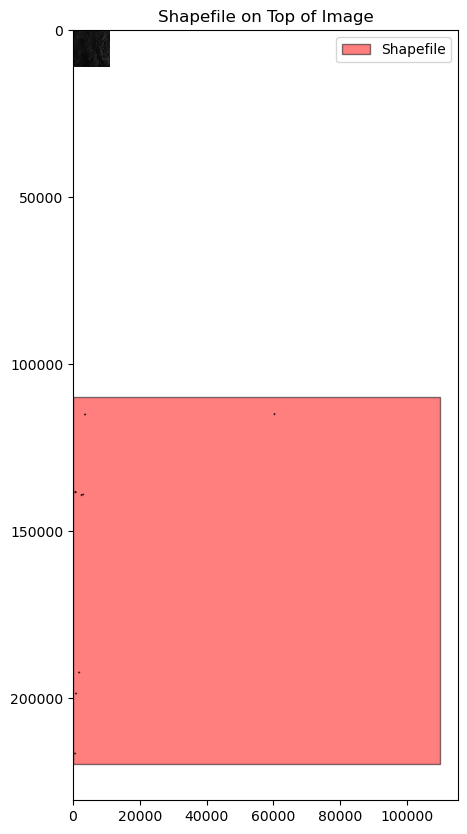

2024-02-05 18:52:01Wait New Raster ::
2024-02-05 18:52:01Your Process is Finished :) 


In [10]:
# def main():
#     current_dir = os.getcwd()

#             # Print the current working directory
#     print("Current Working Directory:", current_dir)
#     global mode, Image_Post, Track_arr
#     print(print_time() + "Application Start ::")
#     while True:
#         t = Timer(systemCooldown, loadCooldown)
#         t.start()
#         t.join()
#         if mode:
#             for Track in Track_arr:
#                 image_track = os.path.join(Image, Track)
#                 if os.path.exists(image_track):
#                     rasters = [r for r in os.listdir(image_track) if r.endswith('B12.jp2')]
#                     if rasters:
#                         mode = False
#                         print(print_time() + "Found NEW Raster :: ")
#                         try:
#                             Raster_Process(Track)
#                         except Exception as e:
#                             print(print_time() + "!!!!!!!!!SYSTEM ERROR !!!!!!!!!!")
#                             print(print_time() + str(e))
#                         print(print_time() + "Wait New Raster ::")
#                 else:
#                     print(f"Directory not found: {image_track}")  # Inform if the directory does not exist

# #Run the main function
# main()

# def main():
#     current_dir = os.getcwd()
#     print("Current Working Directory:", current_dir)
#     global mode, Image_Post, Track_arr
#     print(print_time() + "Application Start ::")
#     while True:  # Use mode as a condition to continue
#         t = Timer(systemCooldown, loadCooldown)
#         t.start()
#         t.join()
#         if mode : # Check again in case mode was changed during cooldown
#             for Track in Track_arr:
#                 image_track = os.path.join(Image, Track)
#                 if os.path.exists(image_track):
#                     rasters = [r for r in os.listdir(image_track) if r.endswith('B12.jp2')]
#                     if rasters:
#                         mode = False # This will stop the loop after processing the available rasters
#                         print(print_time() + "Found NEW Raster :: ")
#                         try:
#                             Raster_Process(Track)
#                         except Exception as e:
#                             print(print_time() + "!!!!!!!!!SYSTEM ERROR !!!!!!!!!!")
#                             print(print_time() + str(e))
#                             print(print_time() + "Wait New Raster ::")
#                         break
                       
#                 else:
#                     print(f"Directory not found: {image_track}")  # Inform if the directory does not exist

# #Run the main function
# main()


def main():
    current_dir = os.getcwd()
    print("Current Working Directory:", current_dir)
    global mode, Image_Post, Track_arr
    print(print_time() + "Application Start ::")
    # Initialize mode to True to enter the loop
    mode = True
    while mode:  # Now the loop will continue as long as mode is True
        t = Timer(systemCooldown, loadCooldown)
        t.start()
        t.join()
        if mode:  # This check is redundant given the while condition, but left for clarity
            for Track in Track_arr:
                image_track = os.path.join(Image, Track)
                if os.path.exists(image_track):
                    rasters = [r for r in os.listdir(image_track) if r.endswith('B12.jp2')]
                    if rasters:
                        print(print_time() + "Found NEW Raster :: ")
                        try:
                            Raster_Process(Track)
                        except Exception as e:
                            print(print_time() + "!!!!!!!!!SYSTEM ERROR !!!!!!!!!!")
                            print(print_time() + str(e))
                            print(print_time() + "Wait New Raster ::")
                        # After processing, set mode to False to prevent further looping
                        print(print_time() + "Your Process is Finished :) ")
                        mode = False
                        break  # Exit the for-loop after processing
                else:
                    print(f"Directory not found: {image_track}")  # Inform if the directory does not exist
        # If mode was set to False, the loop will not execute again

#Run the main function
main()
